# Advanced street network plotting with OSMnx

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Documentation](https://osmnx.readthedocs.io/)
  - [Journal article and citation info](https://geoffboeing.com/publications/osmnx-paper/)
  - [Code repository](https://github.com/gboeing/osmnx)
  - [Examples gallery](https://github.com/gboeing/osmnx-examples)

In [1]:
import matplotlib.pyplot as plt
import osmnx as ox

ox.__version__

'2.0.7'

In [18]:
place = "Oulu, Finland"
G = ox.graph_from_place(place, network_type="drive")

## Color helper functions

You can use the plot module to get colors for plotting.

 - [matplotlib colormap](https://matplotlib.org/stable/users/explain/colors/colormaps.html)

In [19]:
# get n evenly-spaced colors from some matplotlib colormap
ox.plot.get_colors(n=5, cmap="PuBu")

['#fff7fb', '#d0d1e6', '#73a9cf', '#056faf', '#023858']

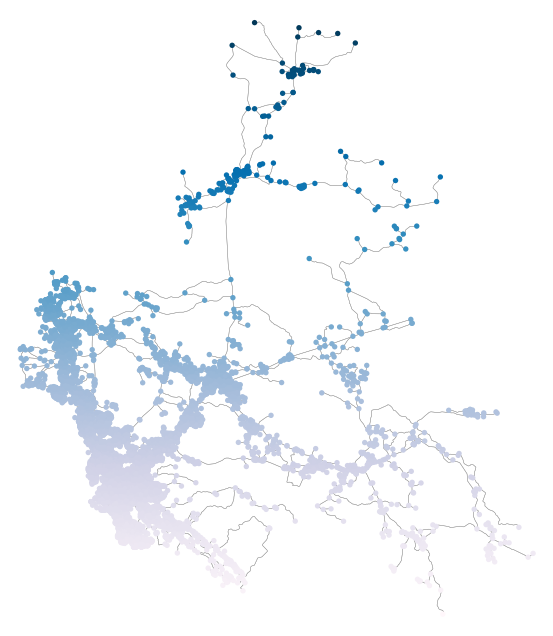

In [20]:
# get node colors by linearly mapping an attribute's values to a colormap
nc = ox.plot.get_node_colors_by_attr(G, attr="y", cmap="PuBu")
fig, ax = ox.plot_graph(G, node_color=nc, edge_linewidth=0.3, bgcolor="w")

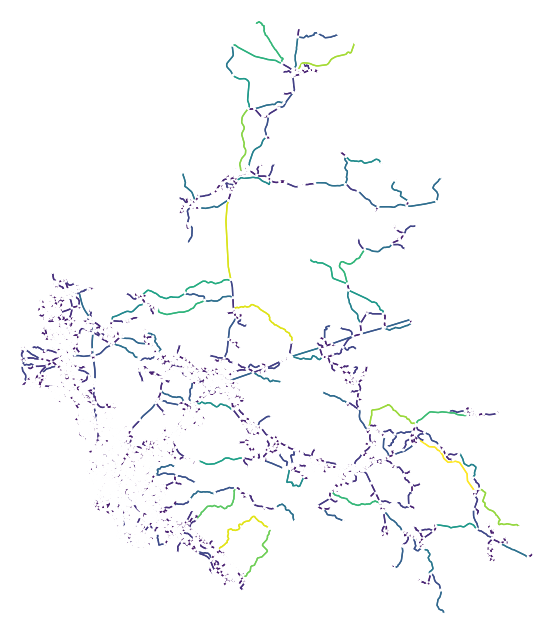

In [21]:
# when num_bins is not None, bin the nodes/edges then assign one color to each bin
# also set equal_size=True for equal-sized quantiles (requires unique bin edges!)
ec = ox.plot.get_edge_colors_by_attr(G, attr="length", num_bins=5)

# otherwise, when num_bins is None (default), linearly map one color to each node/edge by value
ec = ox.plot.get_edge_colors_by_attr(G, attr="length")

# plot the graph with colored edges
fig, ax = ox.plot_graph(G, node_size=5, edge_color=ec, bgcolor="w")

## Other plotting options

See the [documentation](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.plot.plot_graph) for full details.

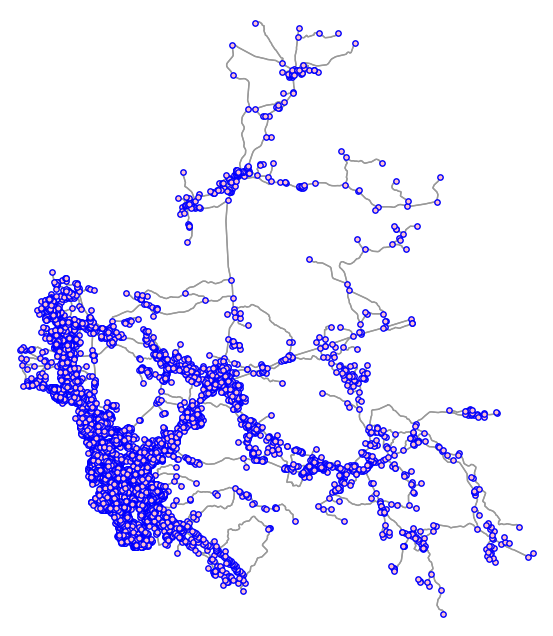

In [22]:
fig, ax = ox.plot_graph(
    G,
    ax=None,  # optionally draw on pre-existing axis
    figsize=(8, 8),  # figure size to create if ax is None
    bgcolor="w",  # background color of the plot
    node_color="pink",  # color of the nodes
    node_size=15,  # size of the nodes: if 0, skip plotting them
    node_alpha=None,  # opacity of the nodes
    node_edgecolor="b",  # color of the nodes' markers' borders
    node_zorder=1,  # zorder to plot nodes: edges are always 1
    edge_color="#999999",  # color of the edges
    edge_linewidth=1,  # width of the edges: if 0, skip plotting them
    edge_alpha=None,  # opacity of the edges
    show=True,  # if True, call pyplot.show() to show the figure
    close=False,  # if True, call pyplot.close() to close the figure
    save=False,  # if True, save figure to disk at filepath
    filepath=None,  # if save is True, the path to the file
    dpi=300,  # if save is True, the resolution of saved file
    bbox=None,  # bounding box to constrain plot
)

Use bbox to constrain the plot (i.e., "zoom") to some precise section of the graph.

For example, perhaps we consolidated nearby intersections to clean-up node clusters and want to inspect our results:

/var/folders/1_/6h4xg3ts1cd8htbp9t8wjyh40000gn/T/ipykernel_30998/2554050003.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  c = ox.graph_to_gdfs(G, edges=False).unary_union.centroid


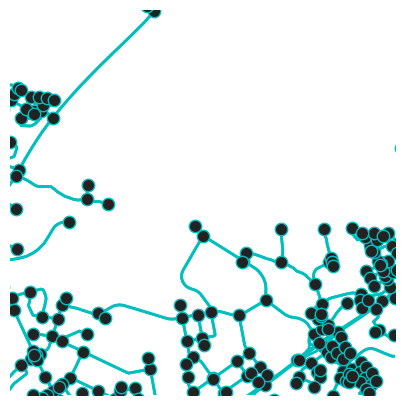

In [23]:
Gc = ox.consolidate_intersections(ox.project_graph(G), dead_ends=True)
c = ox.graph_to_gdfs(G, edges=False).unary_union.centroid
bbox = ox.utils_geo.bbox_from_point(point=(c.y, c.x), dist=2200, project_utm=True)
fig, ax = ox.plot_graph(
    Gc,
    figsize=(5, 5),
    bbox=bbox,
    edge_linewidth=2,
    edge_color="c",
    node_size=80,
    node_color="#222222",
    bgcolor="w",
    node_edgecolor="c",
)

In [24]:
# or save a figure to disk instead of showing it
fig, ax = ox.plot_graph(G, filepath="./images/image.png", save=True, show=False, close=True)

## Plot routes

In [25]:
# impute missing edge speeds and calculate free-flow travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# calculate 3 shortest paths, minimizing travel time
w = "travel_time"
orig, dest = list(G)[10], list(G)[-10]
route1 = ox.shortest_path(G, orig, dest, weight=w)
orig, dest = list(G)[0], list(G)[-1]
route2 = ox.shortest_path(G, orig, dest, weight=w)
orig, dest = list(G)[-100], list(G)[100]
route3 = ox.shortest_path(G, orig, dest, weight=w)

Plot a route with the `plot_graph_route` function.

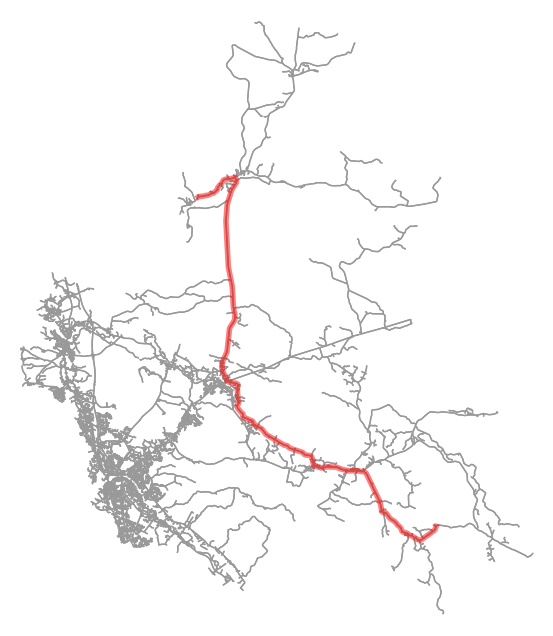

In [26]:
fig, ax = ox.plot_graph_route(G, route1, orig_dest_size=0, node_size=0, bgcolor="w")

In [27]:
# you can also pass any ox.plot_graph parameters as additional keyword args
fig, ax = ox.plot_graph_route(G, route1, save=True, show=False, close=True)

Or plot multiple routes with the `plot_graph_routes` function.

If you provide a list of route colors, each route will receive its own color.

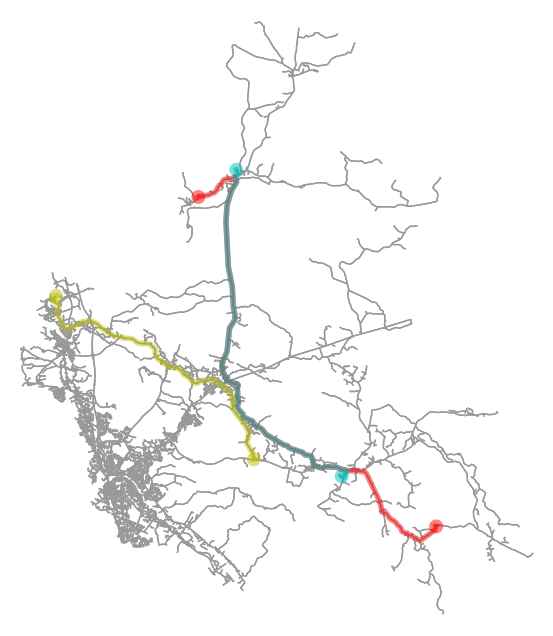

In [28]:
routes = [route1, route2, route3]
rc = ["r", "y", "c"]
fig, ax = ox.plot_graph_routes(G, routes, route_colors=rc, route_linewidth=6, node_size=0, bgcolor="w")

## Annotate a graph's plot

Here we label each street segment with its name. Similar logic would apply to labeling nodes instead.

In [31]:
G2 = ox.graph_from_address("Oulu, Finland", dist=500, network_type="drive")
G2 = ox.convert.to_undirected(G2)

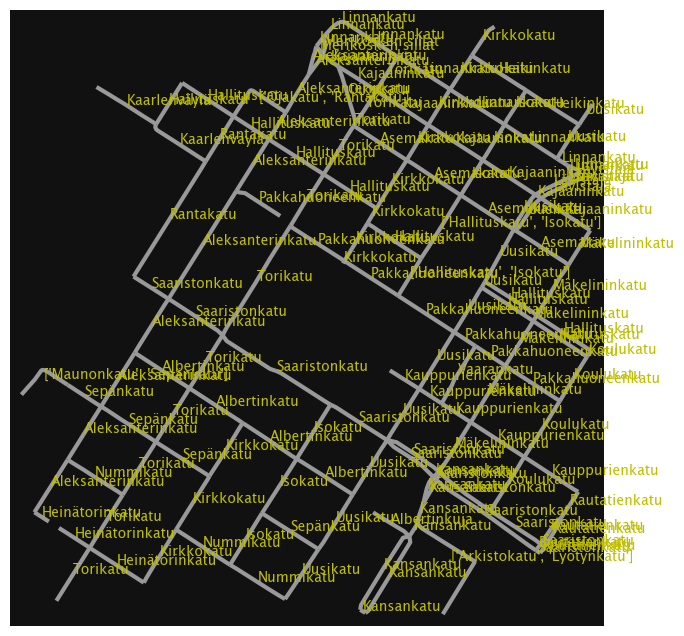

In [32]:
fig, ax = ox.plot_graph(G2, edge_linewidth=3, node_size=0, show=False, close=False)
for _, edge in ox.graph_to_gdfs(G2, nodes=False).fillna("").iterrows():
    text = edge["name"]
    c = edge["geometry"].centroid
    ax.annotate(text, (c.x, c.y), c="y")
plt.show()

## Plot footprints

The `plot_footprints` function lets you plot OSM geospatial features (Polygons and MultiPolygons).

In [34]:
# get all the building footprints in a city
gdf = ox.features_from_place("Oulu, Finland", {"building": True})
gdf.shape

(58025, 323)

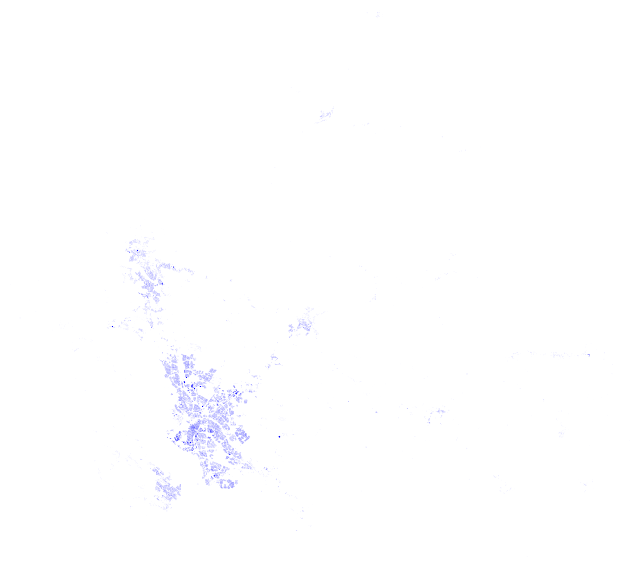

In [35]:
fig, ax = ox.plot_footprints(gdf, bgcolor="w", color="b")

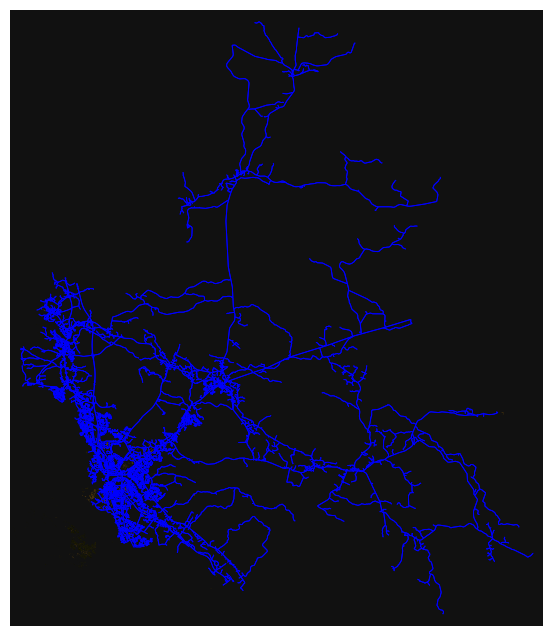

In [36]:
# or plot street network and the geospatial features' footprints together
fig, ax = ox.plot_footprints(gdf, alpha=0.4, show=False)
fig, ax = ox.plot_graph(G, ax=ax, node_size=0, edge_color="b", bgcolor="w", edge_linewidth=0.7)